In [1]:
# Data Handling and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

# Time Series Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA

# Metrics and Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Miscellaneous
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Load the dataset
data = pd.read_excel("/content/drive/MyDrive/Datasets/AirQualityUCI.xlsx")
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [6]:
missing_values = data.isnull().sum()
print(missing_values)

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [12]:
data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
2004-03-10 19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2004-03-10 20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
2004-03-10 21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
2004-03-10 22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


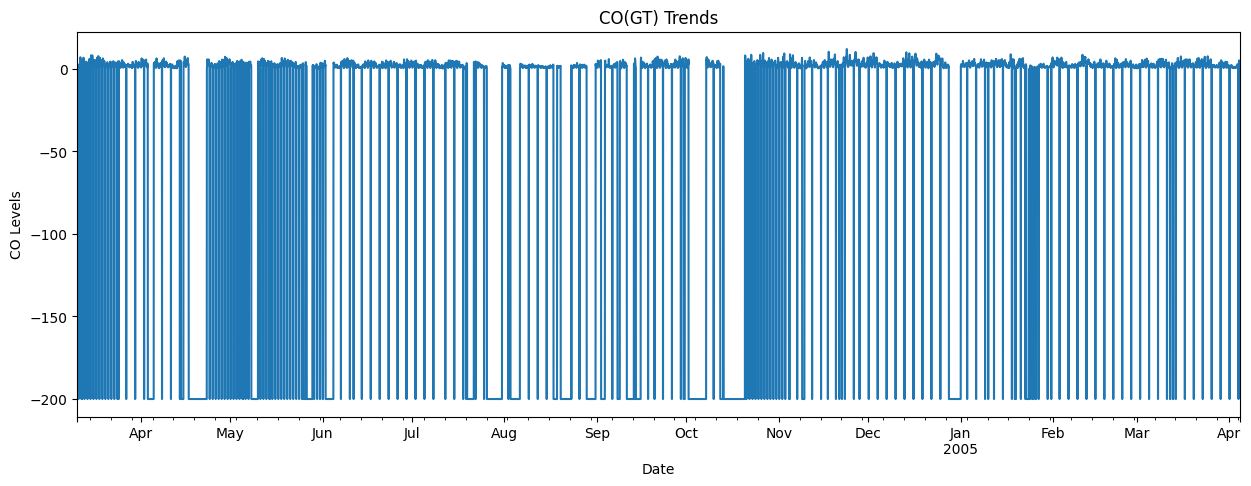

In [13]:
# Plot trends for CO(GT)
data['CO(GT)'].plot(figsize=(15, 5), title='CO(GT) Trends', xlabel='Date', ylabel='CO Levels')
plt.show()

In [14]:
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month

In [15]:
data['CO_MA_24'] = data['CO(GT)'].rolling(window=24).mean()  # 24-hour moving average

In [16]:
data['CO_Lag_1'] = data['CO(GT)'].shift(1)
data['CO_Lag_7'] = data['CO(GT)'].shift(7)  # Weekly lag

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select relevant features and drop missing rows
features = ['CO(GT)', 'CO_MA_24', 'CO_Lag_1', 'CO_Lag_7']
data.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])
        y.append(data[i + sequence_length, -1])
    return np.array(X), np.array(y)

sequence_length = 24
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0605 - val_loss: 0.0184
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0210 - val_loss: 0.0166
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0204 - val_loss: 0.0159
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0168 - val_loss: 0.0151
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0143 - val_loss: 0.0126
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0131 - val_loss: 0.0115
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0120 - val_loss: 0.0075
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 9/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 11/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 12/20
233/233 ━━━━━━━━━━━━━━━━━━

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(data['CO(GT)'], order=(5, 1, 0))
arima_result = arima_model.fit()

# Print ARIMA summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                 9334
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -46624.066
Date:                Sun, 01 Dec 2024   AIC                          93260.132
Time:                        14:16:16   BIC                          93302.980
Sample:                    03-11-2004   HQIC                         93274.686
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5096      0.004   -122.772      0.000      -0.518      -0.501
ar.L2         -0.2914      0.007    -39.614      0.000      -0.306      -0.277
ar.L3         -0.1722      0.011    -15.456      0.0

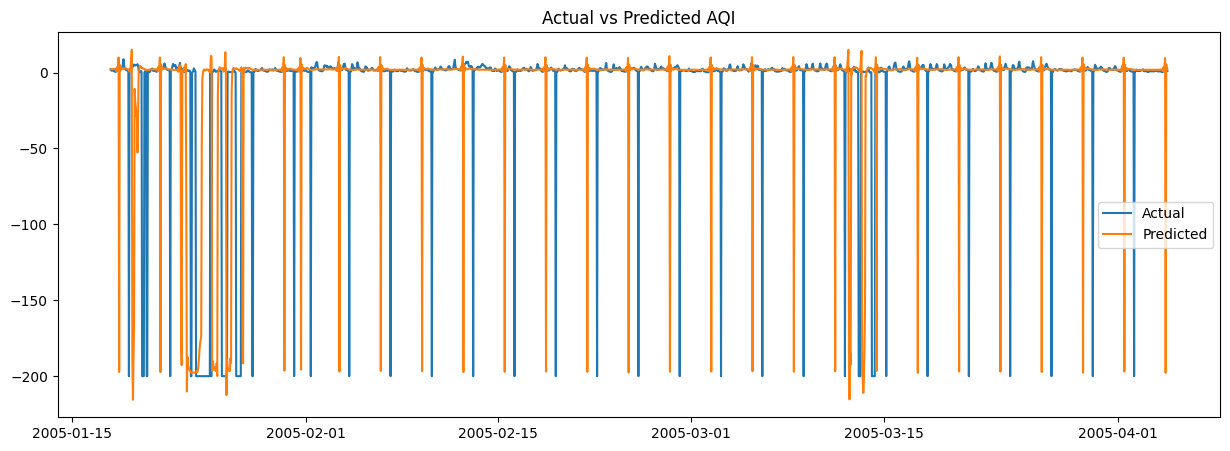

In [21]:
plt.figure(figsize=(15, 5))

# Ensure dimensions match
trimmed_test_data = test_data[:len(data.index[-len(y_test):])]
y_pred_rescaled_trimmed = y_pred_rescaled[:len(data.index[-len(y_test):])]

plt.plot(data.index[-len(y_test):], scaler.inverse_transform(trimmed_test_data)[:, 0], label='Actual')
plt.plot(data.index[-len(y_test):], y_pred_rescaled_trimmed, label='Predicted')

plt.legend()
plt.title("Actual vs Predicted AQI")
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 0.04075230987401616, MAE: 0.009443058767085087
